In [1]:
# Carga del dataset
from numpy import loadtxt
dataset = loadtxt('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', delimiter=',')

In [2]:
# Transformamos a dataframe de pandas
import pandas as pd
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Red Neuronal Keras

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Verificar si se dispone de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dividimos los datos en variables de entrada X y de salida Y
X = data.drop('Outcome', axis=1).values  # Variables independientes
y = data['Outcome'].values  # Variable dependiente

# Separamos los datos en conjuntos de prueba y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar las características
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)  # BCE necesita flotantes
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Crear un DataLoader para manejar lotes
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir el modelo en PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # Salida con 1 neurona para clasificación binaria

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Activación sigmoide para clasificación binaria
        return x

# Inicializar el modelo y mover a la GPU
input_size = X_train_normalized.shape[1]
model = NeuralNetwork(input_size).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()  # Función de pérdida binaria cruzada
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()  # Asegurarse de que las dimensiones sean correctas
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluar el modelo
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        predicted = (outputs > 0.5).float()  # Convertir probabilidades a etiquetas
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Using device: cuda
Epoch 1/20, Loss: 0.6481
Epoch 2/20, Loss: 0.5805
Epoch 3/20, Loss: 0.5025
Epoch 4/20, Loss: 0.4511
Epoch 5/20, Loss: 0.4541
Epoch 6/20, Loss: 0.4344
Epoch 7/20, Loss: 0.4354
Epoch 8/20, Loss: 0.4241
Epoch 9/20, Loss: 0.4199
Epoch 10/20, Loss: 0.4332
Epoch 11/20, Loss: 0.4054
Epoch 12/20, Loss: 0.4118
Epoch 13/20, Loss: 0.4060
Epoch 14/20, Loss: 0.4057
Epoch 15/20, Loss: 0.3786
Epoch 16/20, Loss: 0.3942
Epoch 17/20, Loss: 0.3742
Epoch 18/20, Loss: 0.3815
Epoch 19/20, Loss: 0.3892
Epoch 20/20, Loss: 0.3666
Accuracy: 72.73%


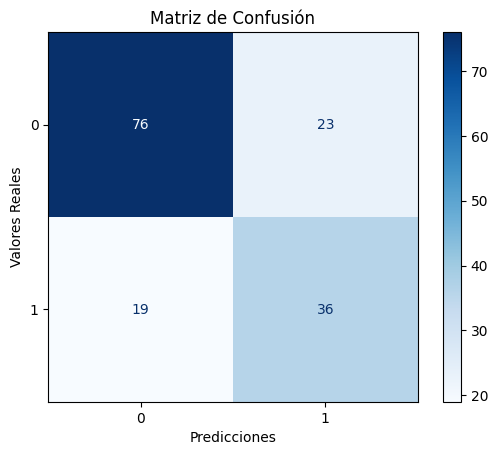

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Establecer el modelo en modo de evaluación
model.eval()

# Obtener las predicciones del modelo
with torch.no_grad():  # Desactivar cálculo de gradientes
    y_pred = model(X_test_tensor).squeeze()  # Salida de probabilidades
    y_pred_classes = (y_pred > 0.5).float()  # Convertir probabilidades a etiquetas binarias

# Generar la matriz de confusión
cm = confusion_matrix(y_test_tensor.cpu(), y_pred_classes.cpu())  # Mover datos a la CPU si están en GPU

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Establecer el modelo en modo de evaluación
model.eval()

# Obtener las predicciones del modelo
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()  # Salida de probabilidades
    y_pred_classes = (y_pred > 0.5).float()  # Convertir probabilidades a etiquetas binarias

# Mover las etiquetas reales a la CPU si están en GPU
y_test_cpu = y_test_tensor.cpu().numpy()
y_pred_classes_cpu = y_pred_classes.cpu().numpy()

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_cpu, y_pred_classes_cpu)

# Calcular especificidad
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Calcular métricas
accuracy = accuracy_score(y_test_cpu, y_pred_classes_cpu)
precision = precision_score(y_test_cpu, y_pred_classes_cpu)
recall = recall_score(y_test_cpu, y_pred_classes_cpu)  
f1 = f1_score(y_test_cpu, y_pred_classes_cpu)

# resultados
print(f"Accuracy: {accuracy * 100:.1f}%")
print(f"Precisión: {precision * 100:.1f}%")
print(f"Sensibilidad (Recall): {recall * 100:.1f}%")
print(f"Especificidad: {specificity * 100:.1f}%")
print(f"Medida F1: {f1 * 100:.1f}%")


Accuracy: 72.7%
Precisión: 61.0%
Sensibilidad (Recall): 65.5%
Especificidad: 76.8%
Medida F1: 63.2%
